In [22]:
"""
Helmet CO2 Accumulation Modeling

Helmet is modeled as constant volume chamber with two inlets and one outlet.
First inlet: Fan blowing air into the helmet at constant volume flow rate
Second inlet: Nostrils that inhale air in the helmet and exhale CO2
Outlet: opening to surroundings

Current concentration of CO2 in the air 0.04%

More than 5% CO2 is harmful (ref: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5380556/pdf/12245_2017_Article_142.pdf)

"""

import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

##################################################################
# INPUTS
##################################################################

# Volume flow rate into the helmet (Liter/min)
VFR = 0.0

# Helmet volume (Liter)
HV = 5.0

# Lung volume (Liter)
LV = 6.0

##################################################################

In [23]:
# Air from surroundings (0.04% CO2 exists in the air)
gas_a = ct.Solution('gri30.xml')
gas_a.TPX = 300.0, ct.one_atm, 'O2:0.20998, N2:0.78998, CO2:0.0004'

# Exhaled gas with fixed composition
# Number of moles of N2 remains the same, only O2 replaced by CO2
# Around 4% CO2 by volume in exhaled gas
gas_b = ct.Solution('gri30.xml')
gas_b.TPX = 310.0, ct.one_atm, 'O2:0.17002, N2:0.78998, CO2:0.04'

# Create reservoirs for the two inlet streams and for the outlet stream.  The
# upsteam reservoirs could be replaced by reactors, which might themselves be
# connected to reactors further upstream. The outlet reservoir could be
# replaced with a reactor with no outlet, if it is desired to integrate the
# composition leaving the mixer in time, or by an arbitrary network of
# downstream reactors.

# Lungs
lungs = ct.Reservoir(gas_b)
lungs.volume = LV*1e-3

# Inlet/Outlet
surrounding = ct.Reservoir(gas_a)

# Initialize conditions in the helmet
helmet = ct.IdealGasReactor(gas_a,energy='on',name='isothermal_reactor')

# Helmet volume m^3
helmet.volume = HV*1e-3

# Calculate mass flow rate into the helmet (kg/s)
MFR = gas_a.density*VFR*1.6667e-5

# 1. Valve connecting surroundings to the helmet
# Only one way flow allowed in valves
mfc1 = ct.Valve(surrounding, helmet, K=10)

# Mass flow controllers connecting 
# 2. nose_out to helmet
mfc2 = ct.MassFlowController(lungs, helmet, mdot=0.0)
# 3. helmet to nose_in
mfc3 = ct.MassFlowController(helmet, lungs, mdot=0.0)

# 4. Valve connecting the helmet to the surroundings
# Only one way flow allowed in valves
outlet = ct.Valve(helmet, surrounding, K=10)

# Create reactornet for helmet
sim = ct.ReactorNet([helmet])
#sim.verbose = True

# Load mass flow rate profile for the simulation 
# of inhalation and exhalation process
mfr_lungs_profile = np.genfromtxt('mass_flow_lungs.dat')

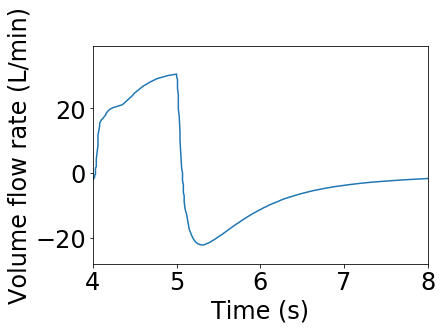

In [24]:
plt.plot(mfr_lungs_profile[:,0],-mfr_lungs_profile[:,1]/lungs.density*60000)
plt.xlim([4,8])
plt.xlabel('Time (s)')
plt.ylabel('Volume flow rate (L/min)')
plt.show()

In [25]:
# Initial time and state
time = 0.0
states = ct.SolutionArray(gas_a, extra=['t'])

# Track volume flow rates
vfr1 = []
vfr2 = []
vfr3 = []
vfr_outlet = []

# Helmet mass and pressure
h_mass = []
h_p = []

while time <= 55:
    
    # Track volume flow rates (L/min)
    vfr1.append(mfc1.mdot(time)/surrounding.density*60000)
    vfr2.append(mfc2.mdot(time)/lungs.density*60000)
    vfr3.append(mfc3.mdot(time)/helmet.density*60000)
    vfr_outlet.append(outlet.mdot(time)/helmet.density*60000)
    
    # Track mass (kg) and pressure (Pa) of the helmet 
    h_mass.append(helmet.mass)
    h_p.append(helmet.thermo.P)
    
    # Advance time
    time += 1.e-2
    
    # Interpolate mass flow rate in/out of lungs
    mfr_lungs = np.interp(time,mfr_lungs_profile[:,0],-mfr_lungs_profile[:,1])
    
    # If mfr_l > 0, the gas flows out of lungs
    # else into lungs
    if mfr_lungs < 0.0:
        mfc2.set_mass_flow_rate(-mfr_lungs)
        mfc3.set_mass_flow_rate(0.0)
    else:
        mfc2.set_mass_flow_rate(0.0)
        mfc3.set_mass_flow_rate(mfr_lungs)

    # Time integration
    sim.advance(time)
    
    states.append(helmet.thermo.state, t=time)
    #print('%10.3e %10.3f %10.3f %14.6e' % (sim.time, helmet.T,helmet.thermo.P, helmet.thermo.u))

In [26]:
# Convert lists to numpy arrays
np_vfr1 = np.array(vfr1)    
np_vfr2 = np.array(vfr2)
np_vfr3 = np.array(vfr3)
np_vfr_outlet = np.array(vfr_outlet)
np_h_mass = np.array(h_mass)
np_h_p = np.array(h_p)

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

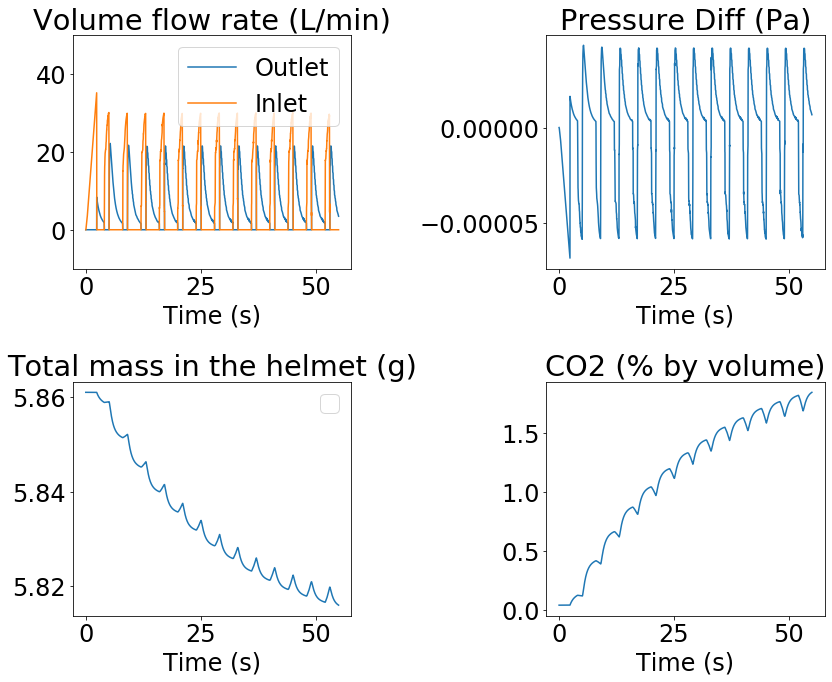

In [27]:
# Plot the results if matplotlib is installed.
# See http://matplotlib.org/ to get it.

plt.clf()
plt.figure(num=None, figsize=(12, 10))
plt.rcParams.update({'font.size': 24})
plt.subplot(2, 2, 1)
#plt.plot(states.t,np_vfr3)
plt.plot(states.t,np_vfr_outlet,label='Outlet')
plt.plot(states.t,np_vfr1,label='Inlet')
plt.xlabel('Time (s)')
plt.title('Volume flow rate (L/min)')
plt.ylim([-10,50])
plt.legend(loc='best')
plt.subplot(2, 2, 2)
plt.plot(states.t,(np_h_p-101325))
plt.xlabel('Time (s)')
plt.title('Pressure Diff (Pa)')
plt.subplot(2, 2, 3)
#plt.plot(states.t, states.X[:,gas_a.species_index('N2')]*100,label='N2')
#plt.plot(states.t, states.X[:,gas_a.species_index('O2')]*100,label='O2')
plt.plot(states.t,np_h_mass*1e3)
plt.xlabel('Time (s)')
plt.title('Total mass in the helmet (g)')
plt.legend(loc='best')
plt.subplot(2, 2, 4)
plt.plot(states.t, states.X[:,gas_a.species_index('CO2')]*100)
plt.xlabel('Time (s)')
plt.title('CO2 (% by volume)')
plt.tight_layout()
plt.savefig('CO2_BuildupModeling.pdf')
plt.show()